<img src="./images/eu_banner.png" alt="EU Banner" width="100%"/>

# **LISFLOOD Use Case - 0) Catchment Overview**
---

This use case intends to introduce the basic mechanics of the hydrological model [LISFLOOD](https://github.com/ec-jrc/lisflood-code/).
<br>
In this exercise, the objective is to read and visualize some of the static and dynamic maps as well as meteorological forcings required in LISFLOOD. <br>
As we can't discuss all input files in detail, a full list with details can be found [here](https://ec-jrc.github.io/lisflood-code/4_annex_input-files/).

## **0) Input Data**

LISFLOOD contains dozens of input files, more precisely maps that are either static (no time dimension) or dynamic (with time dimension). <br>
Besides, LISFLOODs meteorological inputs will be counted and explored here as a standalone category of the inputs.<br>
In our example model of the Aisén River, all input maps (meteo, static, dynamic) are found in the **`maps`** and **`meteo`** folder.

Meteorological input variables refer to:
* Daily precipitation rates, indicated as **`pr`** or **`tp`** (mm/d)
* Average daily temperature, indicated as **`Tavg`** or **`ta`** (°C)
* Daily potential evaporation rate from free water surface, indicated as **`e`** or **`E0`** (mm/d)
* Daily potential evaporation rate from bare soil, indicated as **`es`** or **`ES0`** (mm/d)
* Daily potential evaporation rate from reference crop, indicated as **`et`** or **`ET0`** (mm/d)

Note, users are thus obliged to provide potential evapotranspiration maps to run the model. <br> 
The preperation of the evapotranspiration maps can be done for example using [LISVAP](https://github.com/ec-jrc/lisflood-lisvap). <br>
As LISVAP uses Penman-Monteith to calculate potential evapotranspiration, additional inputs are required to derive the potential evapotranspiration maps. <br>

***

### **Meteorological Check**
We will now have a look at the temperature, precipitation and evapotranspiration regime of our studz area via Python. <br>
This refers to an important step every modeller should undertake before starting the actual modeling work.<br>
A meteorological check helps the user to get an idea on what to expect hydrologically in terms of general dryness and wetness (aridity), temporal (seasonal) behavior,<br>
but also for plausibility reasons whether annual averages & units are reasonable.

In our example we have one file per variable and year and a prefix *"glofas_"*, e.g. for temperature **`glofas_ta_YYYY`**, where YYYY indicates the specific year.<br>
Besides, as each pixel in LISFLOOD can have fractions of water, bare soil and vegetation we cannot easily get a representative reference evapotranspiration value per Pixel.<br>
We therefore will show the individual water, bare soil and reference crop evapotranspirations individually for the basin scale in comparison to precipitation.

Note: as LISVAP provides the individual reference evapotranspirations for the 3 different land surfaces, the real potential evapotranspiration values that consider land use specific information (e.g.through crop coefficients) are internally computed in LISFLOOD and incorporate additional inputs. 

In [1]:
from pathlib import Path
from datetime import datetime
import pandas as pd

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# define paths
path_model = Path('../meteo/meteo_clipped')

# read temp
VAR = "ta"
files = sorted(path_model.glob(f'glofas_{VAR}_*.nc'))
tavg = xr.open_mfdataset(files, combine="by_coords")

# read precip
VAR = "tp"
files = sorted(path_model.glob(f'glofas_{VAR}_*.nc'))
precip = xr.open_mfdataset(files, combine="by_coords")

# read E0 (pot. open water evaporation)
VAR = "e0"
files = sorted(path_model.glob(f'glofas_{VAR}_*.nc'))
e0 = xr.open_mfdataset(files, combine="by_coords")

# read ES0 (pot. soil evaporation)
VAR = "eS0"
files = sorted(path_model.glob(f'glofas_{VAR}_*.nc'))
es0 = xr.open_mfdataset(files, combine="by_coords")

# read ET0 (pot. plant transpiration)
VAR = "eT0"
files = sorted(path_model.glob(f'glofas_{VAR}_*.nc'))
et0 = xr.open_mfdataset(files, combine="by_coords")

Now that all meteorological variables are properly read, we will investigate the basin characteristics further.<br>
However, first we will sum up the individual potential evapotranspiration files to get a total potential evapotranspiration value.

In [4]:
# sum potential evapotranspiration
pet = e0['e0'] + es0['eS0'] + et0['eT0']
# make a ds for consistency
pet = pet.to_dataset(name='pet')


Since timestamps refer to 00:00 (midnight) at the end of the daily time step, for instance 2020-01-01 00:00 represents the end of 31 December 2019.
For aggregation purposes we will shift the timestamp of the variables by 1 day.

In [5]:
pet['time'] = pet['time'] - pd.Timedelta(days=1)
e0['time'] = e0['time'] - pd.Timedelta(days=1)
es0['time'] = es0['time'] - pd.Timedelta(days=1)
et0['time'] = et0['time'] - pd.Timedelta(days=1)
tavg['time'] = tavg['time'] - pd.Timedelta(days=1)
precip['time'] = precip['time'] - pd.Timedelta(days=1)

Now let us have a look at the meteorological variables and what it tells us about the study area.
For this, we first create monthly, annual and seasonal arrays.<br>
First we will check annual average maps of the variables

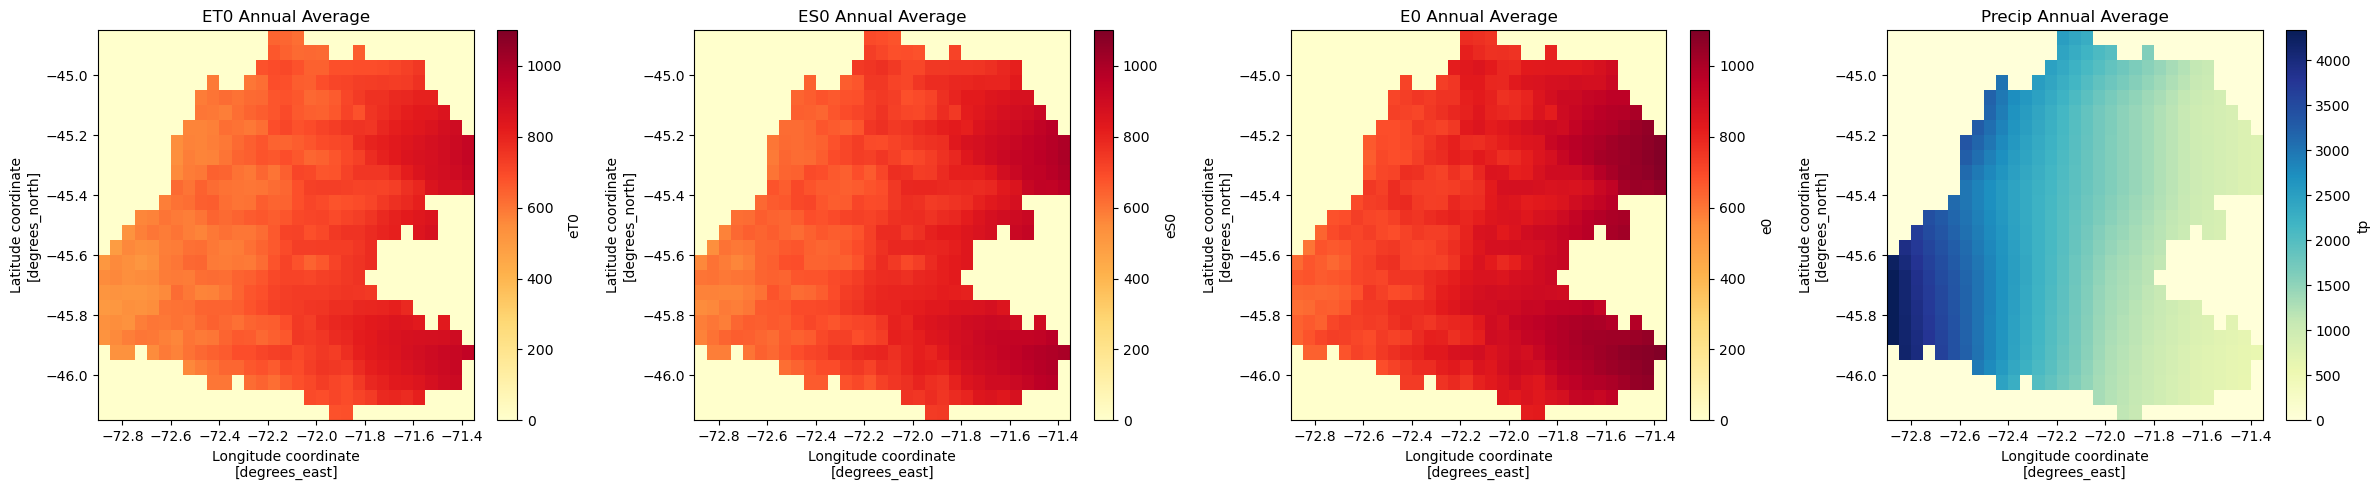

In [43]:
# Annual
pet_a = pet.resample(time='Y').sum()
et0_a = et0.resample(time='Y').sum()
es0_a = es0.resample(time='Y').sum()
e0_a = e0.resample(time='Y').sum()
precip_a = precip.resample(time='Y').sum()
tavg_a = tavg.resample(time='Y').mean()

# Annual Averages
pet_aa = pet_a.mean(dim="time")
et0_aa = et0_a.mean(dim="time")
e0_aa = e0_a.mean(dim="time")
es0_aa = es0_a.mean(dim="time")
precip_aa = precip_a.mean(dim="time")
tavg_aa = tavg_a.mean(dim="time")


# actual figure
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# ET0 Annual Average
et0_aa['eT0'].plot(ax=axes[0], cmap='YlOrRd', vmin=0,vmax=1100)
axes[0].set_title('ET0 Annual Average')

# ES0 Annual Average
es0_aa['eS0'].plot(ax=axes[1], cmap='YlOrRd', vmin=0,vmax=1100)
axes[1].set_title('ES0 Annual Average')

# E0 Annual Average
e0_aa['e0'].plot(ax=axes[2], cmap='YlOrRd', vmin=0,vmax=1100)
axes[2].set_title('E0 Annual Average')

# Precipitation Annual Average
precip_aa['tp'].plot(ax=axes[3], cmap='YlGnBu')
axes[3].set_title('Precip Annual Average')

fig.tight_layout()



In the annual average plots can see already some precipitation and potential evapotranspiration gradients from West to East. <br>
We also can see that the coastal area in the East are very wet with precipitation values of up 4,000 mm according to out input data.<br>
The 3 different reference evapotranspiration maps indicate that the potential evapotranspiration values are very comparable where (logically) the open water part exceeds the values of the others.

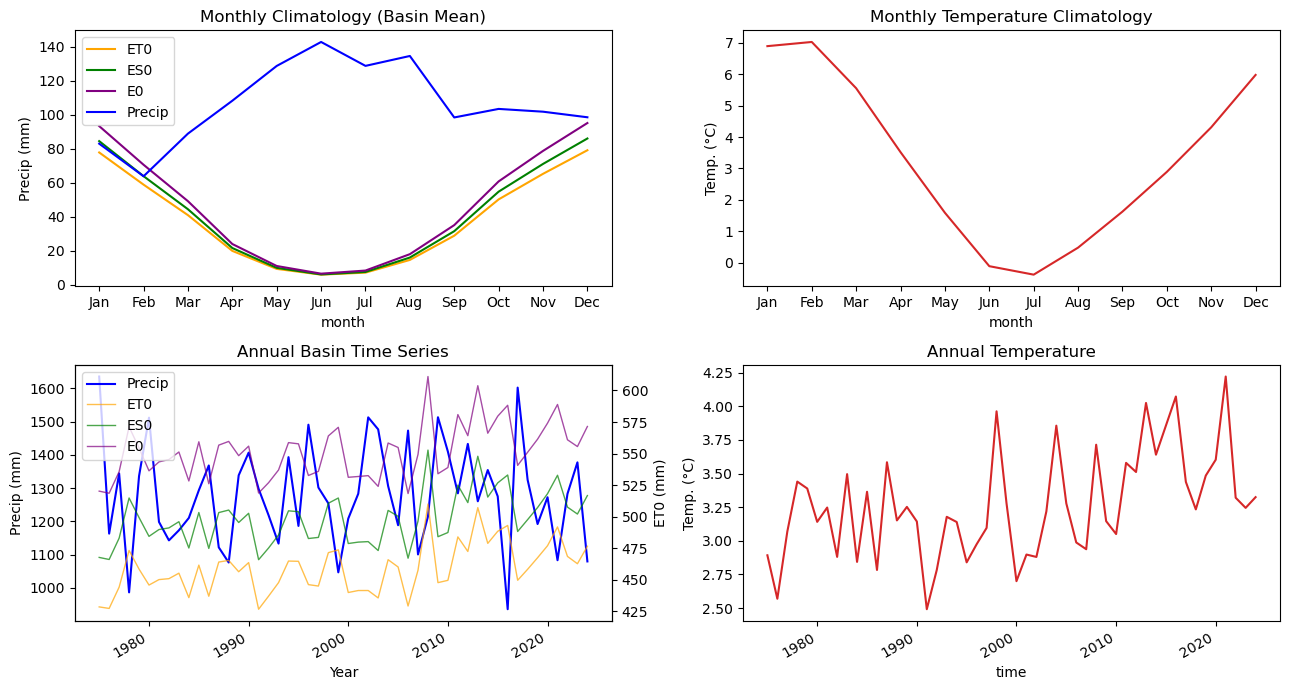

In [35]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# --- Create basin averages ---
et0_basin = et0.mean(dim=["lat", "lon"], skipna=True)['eT0']
es0_basin = es0.mean(dim=["lat", "lon"], skipna=True)['eS0']
e0_basin  = e0.mean(dim=["lat", "lon"], skipna=True)['e0']
precip_basin = precip.mean(dim=["lat", "lon"], skipna=True)['tp']
tavg_basin   = tavg.mean(dim=["lat", "lon"], skipna=True)['ta']

# --- Resample monthly and annual ---
et0_m    = et0_basin.resample(time="MS").sum()
es0_m    = es0_basin.resample(time="MS").sum()
e0_m     = e0_basin.resample(time="MS").sum()
precip_m = precip_basin.resample(time="MS").sum()
tavg_m   = tavg_basin.resample(time="MS").mean()

et0_a    = et0_basin.resample(time="YS").sum()
es0_a    = es0_basin.resample(time="YS").sum()
e0_a     = e0_basin.resample(time="YS").sum()
precip_a = precip_basin.resample(time="YS").sum()
tavg_a   = tavg_basin.resample(time="YS").mean()

# --- Monthly climatology ---
et0_s    = et0_m.groupby("time.month").mean()
es0_s    = es0_m.groupby("time.month").mean()
e0_s     = e0_m.groupby("time.month").mean()
precip_s = precip_m.groupby("time.month").mean()
tavg_s   = tavg_m.groupby("time.month").mean()

# --- Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(13, 7))

# --- Monthly climatology (ET0, ES0, E0 + Precip) ---
et0_s.plot(ax=axes[0,0], label="ET0", color="orange")
es0_s.plot(ax=axes[0,0], label="ES0", color="green")
e0_s.plot(ax=axes[0,0], label="E0", color="purple")
precip_s.plot(ax=axes[0,0], label="Precip", color="b")
axes[0,0].set_title("Monthly Climatology (Basin Mean)")
axes[0,0].set_ylabel("Precip (mm)")
axes[0,0].set_xticks(range(1,13))
axes[0,0].set_xticklabels(months)
axes[0,0].legend()

# Monthly temperature climatology
tavg_s.plot(ax=axes[0,1], color="tab:red")
axes[0,1].set_title("Monthly Temperature Climatology")
axes[0,1].set_ylabel("Temp. (°C)")
axes[0,1].set_xticks(range(1,13))
axes[0,1].set_xticklabels(months)

# --- Annual time series ---
# Precipitation on left axis
precip_a.plot(ax=axes[1,0], label="Precip", color="b",lw=1.5)
axes[1,0].set_title("Annual Basin Time Series")
axes[1,0].set_ylabel("Precip (mm)")
axes[1,0].set_xlabel("Year")

# Create secondary y-axis for ET variables
ax2 = axes[1,0].twinx()
et0_a.plot(ax=ax2, label="ET0", color="orange",lw=1,alpha=0.7)
es0_a.plot(ax=ax2, label="ES0", color="green",lw=1,alpha=0.7)
e0_a.plot(ax=ax2, label="E0", color="purple",lw=1,alpha=0.7)
ax2.set_ylabel("ET0 (mm)")

# Combine legends
lines, labels = axes[1,0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Annual temperature
tavg_a.plot(ax=axes[1,1], color="tab:red")
axes[1,1].set_title("Annual Temperature")
axes[1,1].set_ylabel("Temp. (°C)")

fig.tight_layout()


In [42]:
# check aridity index 
# ai = precip_a.tp.mean(dim="time").values/es0_a.pet.mean(dim="time").values
ai = precip_a.mean(dim="time").values/et0_a.mean(dim="time").values
# ai = precip_a.tp.mean(dim="time").values/e0_a.pet.mean(dim="time").values
print(f"Aridity Index for the whole time series is {ai:.2f}")

Aridity Index for the whole time series is 2.79


We immediately notice the notably smaller variability of PET compared to precipitation, as well as the contrasting seasonal patterns of both (rainy season in Winter of Southern Hemisphere when temperatures are low).<br>
Besides, we can see that there is a slight trend in the annual temperature time series from (approx.) the 2000s onward, which gives you already some hydrological implications for your modeling.<br>
The seasonality in precipitation, peaking in May to August, suggests that this will be our high-flow period. <br>
Lastly, the aridity index, calculated as the quotient of long-term precipitation and long-term PET suggests a (very) humid climate type of the basin, and therefore not water-limited.<br>
What we also nicely see is that in the wet Winter period of the basin, mean monthly temperatures are around 0 degrees celsius. 

---

### **Static Maps Check**

Next, we will have a look at some static maps, variables that do not change over time and serve as important inputs to the model.
We will have a look at:
* General catchment characteristics
* Some soil properties
* Land use information

As a start let us figure out how big our catchment actually is!<br>
For that we can check the UpArea.nc file which gives us the upstream area for each cell in the catchment and thus indirectly indicates the stream network as well! <br>
As we are interested in the catchment area at the outlet, we also load the outlet location do get this information.


Upstream area at the outlet: 11590.360 km2


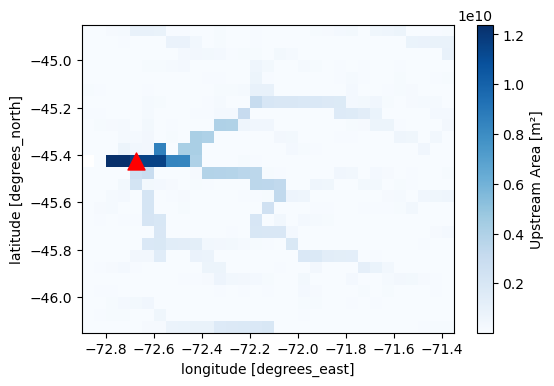

In [42]:
# read input
path_model = Path('..')
uparea_file = "upArea_unclipped.nc"
outlet_file = "outlet.txt"
uparea_orig = xr.open_dataset(path_model / "maps" / uparea_file)
outlet = pd.read_csv(path_model / "station" / outlet_file,delimiter="\t", names=["lon", "lat", "id"])
# map
fig, ax = plt.subplots(figsize=(6,4))
uparea_orig.Band1.plot.pcolormesh(ax=ax,cbar_kwargs={'label': 'Upstream Area [m²]'},cmap='Blues')
ax.scatter(
    outlet['lon'],
    outlet['lat'],
    color='red',      # marker color
    s=150,            # marker size
    marker='^',       # circle
);

# get outlet basin size in km2
area_outlet = uparea_orig["Band1"].sel(
    lat=outlet["lat"].values,
    lon=outlet["lon"].values,
    method="nearest"
).item()/10**6
print(f"Upstream area at the outlet: {area_outlet:.3f} km2")

Now let us explore some of the soil properties, in detail we are interested in:
* hydraulic conductivities
* saturated water contents

...across different soil layers.

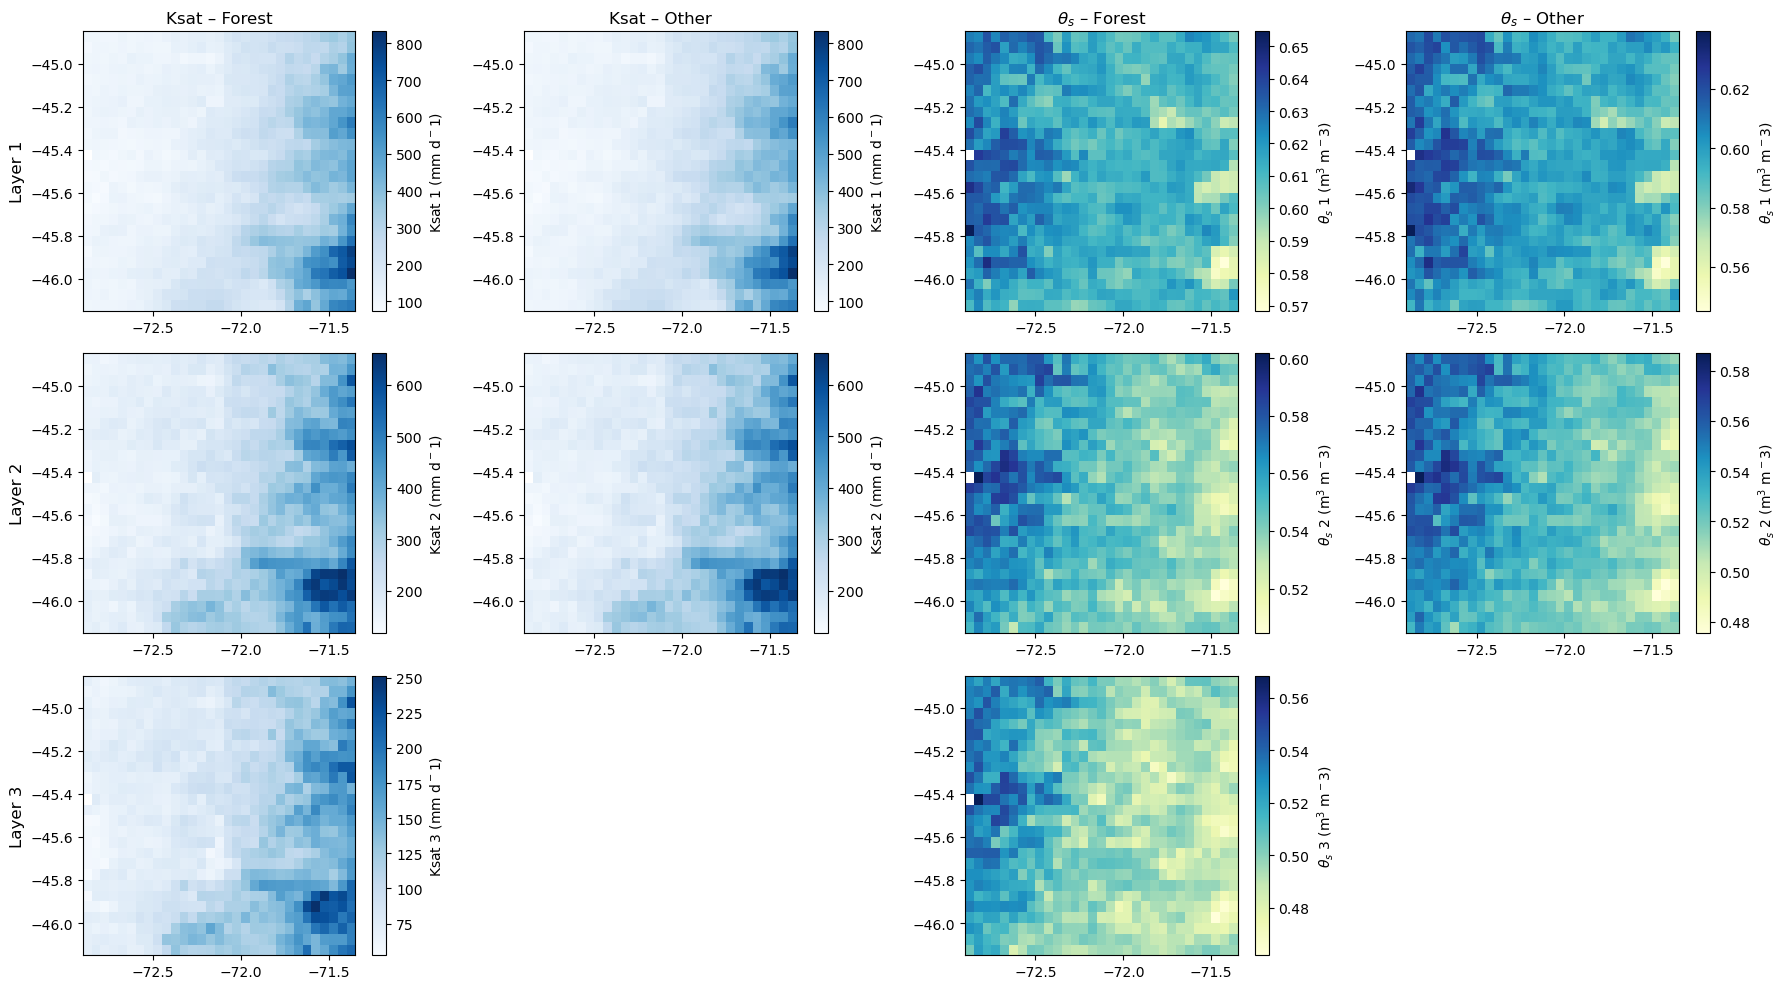

In [110]:
# load maps:
#     "ksat" is the saturated hydraulic conductivity of the soil in (mm/d)
#     "thetas" is the volumetric water content of the saturated soil in (m3/m3)
#     "1", "2", "3" refer to the soil layers (note that for layer 3 no distinction between forest & other land uses is done anymore)
#     "f" refers to the fraction of soil covered by forests (note that for layer 3 no distinction between forest & other land uses is done anymore)
#     "a" refers to the fraction of other land use classes than forest (note that for layer 3 no distinction between forest & other land uses is done anymore)
# define paths
path_model = Path('../maps')
# define variable names
variables = ['ksat1_f', 'ksat1_o' 'ksat2_f', 'ksat2_o', 'ksat3', 'thetas1_f', 'thetas1_o', 'thetas2_f', 'thetas2_o', 'thetas3']
variables = [
    'ksat1_f', 'ksat1_o',
    'ksat2_f', 'ksat2_o',
    'ksat3',
    'thetas1_f', 'thetas1_o',
    'thetas2_f', 'thetas2_o',
    'thetas3'
]
suffix = "Global2_03min"
# read variables
soils = {}
for var in variables:
    ds = xr.open_dataset(path_model / f'{var}_{suffix}.nc')
    ds.close()
    soils[var] = ds['Band1']

# plot maps
fig, axes = plt.subplots(nrows=3, ncols=4,figsize=(18, 10))

layers = [1, 2, 3]

for i, layer in enumerate(layers):

    # --- KSAT ---
    if layer < 3:
        soils[f'ksat{layer}_f'].plot(
            ax=axes[i, 0], cmap='Blues',
            cbar_kwargs={'label': rf'Ksat {layer} (mm d$^{-1}$)'}
        )
        soils[f'ksat{layer}_o'].plot(
            ax=axes[i, 1], cmap='Blues',
            cbar_kwargs={'label': rf'Ksat {layer} (mm d$^{-1}$)'}
        )
    else:
        soils['ksat3'].plot(
            ax=axes[i, 0], cmap='Blues',
            cbar_kwargs={'label': rf'Ksat {layer} (mm d$^{-1}$)'}
        )
        axes[i, 1].axis('off')
        # soils['ksat3'].plot(
        #     ax=axes[i, 1], cmap='Blues',
        #     cbar_kwargs={'label': rf'Ksat {layer} (mm d$^{-1}$)'}
        # )

    # --- THETAS ---
    if layer < 3:
        soils[f'thetas{layer}_f'].plot(
            ax=axes[i, 2], cmap='YlGnBu',
            cbar_kwargs={'label': rf'$\theta_s$ {layer} (m$^3$ m$^{-3}$)'}
        )
        soils[f'thetas{layer}_o'].plot(
            ax=axes[i, 3], cmap='YlGnBu',
            cbar_kwargs={'label': rf'$\theta_s$ {layer} (m$^3$ m$^{-3}$)'}
        )
    else:
        soils['thetas3'].plot(
            ax=axes[i, 2], cmap='YlGnBu',
            cbar_kwargs={'label': rf'$\theta_s$ {layer} (m$^3$ m$^{-3}$)'}
        )
        axes[i, 3].axis('off')
        # soils['thetas3'].plot(
        #     ax=axes[i, 3], cmap='YlGnBu',
        #     cbar_kwargs={'label': rf'$\theta_s$ {layer} (m$^3$ m$^{-3}$)'}
        # )

    # Row labels
    axes[i, 0].set_ylabel('')
    axes[i, 1].set_ylabel('')
    axes[i, 2].set_ylabel('')
    axes[i, 3].set_ylabel('')
    axes[i, 0].set_ylabel(f'Layer {layer}', fontsize=12)

# Clean axes
for ax in axes.flat:
#     ax.axis('off')
    ax.set_title("")
    ax.set_xlabel("")


# Column titles
col_titles = [
    'Ksat – Forest', 'Ksat – Other',
    r'$\theta_s$ – Forest', r'$\theta_s$ – Other'
]

for j, title in enumerate(col_titles):
    axes[0, j].set_title(title, fontsize=12)

fig.tight_layout()

We will now have a look at the saturated hydraulic conductivity and investigate the differences between the layers in a more differentiable way.
For this let us plot five boxplots.

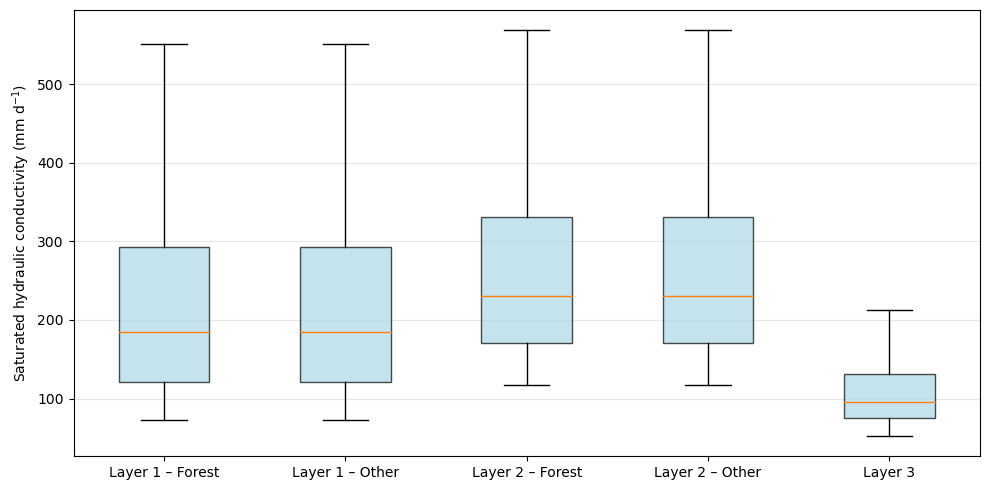

In [121]:
ksat_vars = [
    'ksat1_f', 'ksat1_o',
    'ksat2_f', 'ksat2_o',
    'ksat3'
]

labels = [
    'Layer 1 – Forest',
    'Layer 1 – Other',
    'Layer 2 – Forest',
    'Layer 2 – Other',
    'Layer 3'
]

data = []

for var in ksat_vars:
    da = soils[var]
    
    # mask invalid values
    da = da.where(da > 0)
    # flatten lat/lon → 1D
    values = da.values.flatten()
    
    # drop NaNs
    values = values[~np.isnan(values)]
    
    data.append(values)

# plot
fig, ax = plt.subplots(figsize=(10, 5))

bp = ax.boxplot(
    data,
    labels=labels,
    showfliers=False,      # cleaner for skewed Ksat
    patch_artist=True
)

# Styling
for box in bp['boxes']:
    box.set(facecolor='lightblue', alpha=0.7)

ax.set_ylabel(r'Saturated hydraulic conductivity (mm d$^{-1}$)')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

You probably notice that the **forest** and **other** land use classes hydraulic conductivity values look suspiciously similar.<br>
In our example we did not distinguish the soil properties for a specific pixel further based on land use.

---

### **Dynamic Maps Check**

Let us load and identify the land use maps, which count as static maps in LISFLOOD as they provide fractions of land use classes per pixel.<br>
The land use classes considered in LISFLOOD are:
* Forest
* Other (e.g., non-forested natural such as grassland, agricultural, etc.)
* Sealed
* Water
* Rice

Fractions can be provided as time series to model and consider land use changes or (as in our example) users can use static land-use maps without a time dimension.<br>
Therefore the land use fraction can be considered as dynamic maps, although in our example they are static.
We will map the different land use fractions for the basin scale. 

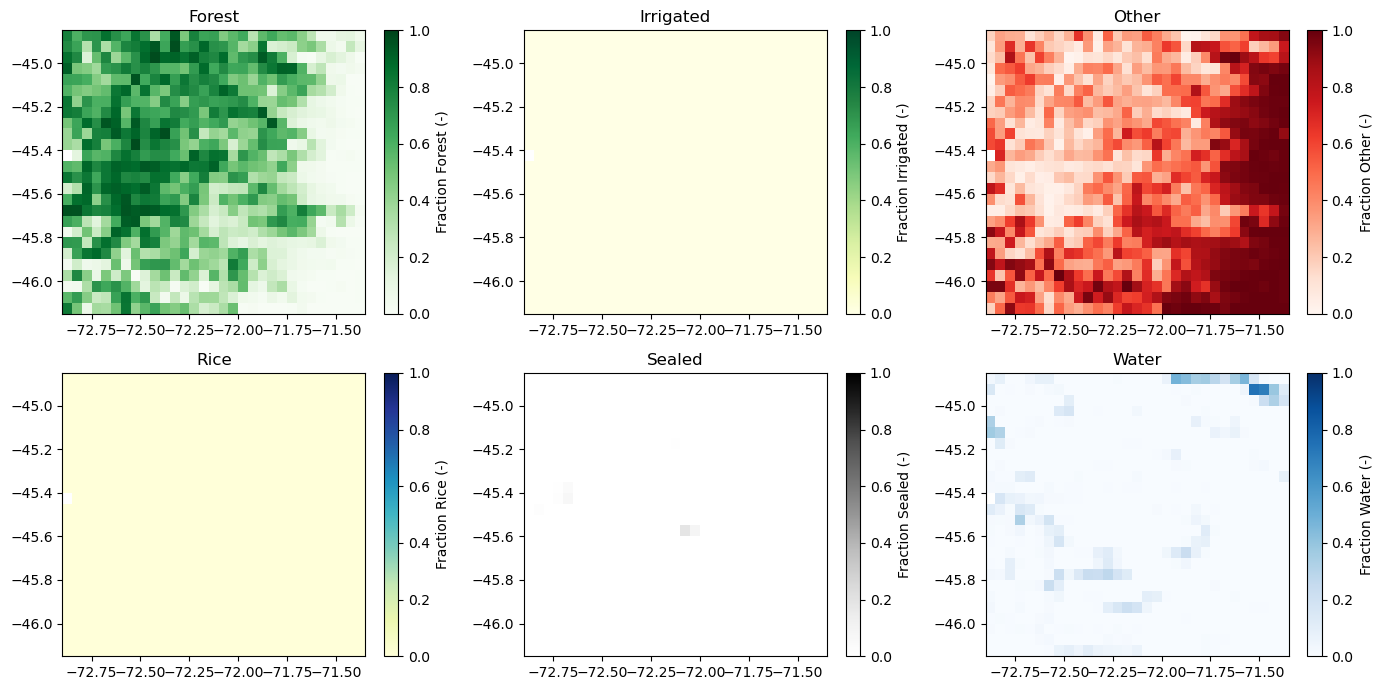

In [159]:
# define paths
path_model = Path('../maps')
# define variables
variables =  ['forest', 'irrigated', 'other', 'rice', 'sealed', 'water']
land_use = {}
for var in variables:
    if var in(["other","irrigated"]):
        suffix = "Global2_03min"
    else:
        suffix = "Global_03min"

    da = xr.open_dataset(path_model / f'frac{var}_{suffix}.nc')
    da.close()
    land_use[var] = da

# define colormaps 
cmaps = {
    'forest':     'Greens',    # forest vegetation
    'irrigated':  'YlGn',      # agriculture / crops 
    'rice':       'YlGnBu',    # wet agriculture (green → blue)
    'water':      'Blues',     # water
    'sealed':     'Greys',     # urban / impervious
    'other':      'Reds',   # mixed / grass / range etc.
}

# plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 7))

axes = axes.flatten()

for ax, (name, ds) in zip(axes, land_use.items()):
    da = ds.Band1  # Dataset → DataArray

    da.plot(ax=ax, cmap = cmaps[name],vmin=0,vmax=1, cbar_kwargs={"label": f"Fraction {name.capitalize()} (-)"})

    ax.set_title(name.capitalize())
    ax.set_xlabel("")
    ax.set_ylabel("")
fig.tight_layout()


If you want to check whether your fractions were properly set, you can stack the fractions and sum them to see whether everything is 1.<br>
The outlet location btw. is a NaN value and thus can be ignored. <br>
It should look similar to below:

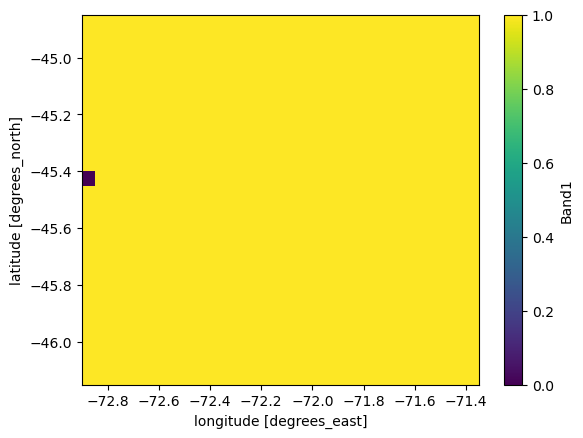

In [ ]:
da_stack = xr.concat([ds.Band1 for ds in land_use.values()], dim="class")
da_stack.sum(dim="class").plot()

And what are our dominant land use clases in the study area? <br>
Let us have a look and from our maps we expect the forest and other class to be dominant!

In [182]:
print(f"The catchment contains a fraction of {land_use['forest'].Band1.mean().item():.3f} forest")
print(f"The catchment contains a fraction of {land_use['other'].Band1.mean().item():.3f} other")
print(f"The catchment contains a fraction of {land_use['water'].Band1.mean().item():.3f} water")
print(f"The catchment contains a fraction of {land_use['sealed'].Band1.mean().item():.3f} sealed areas")


The catchment contains a fraction of 0.452 forest
The catchment contains a fraction of 0.526 other
The catchment contains a fraction of 0.021 water
The catchment contains a fraction of 0.001 sealed areas


To finish this tutorial we will have a look at the transient time series of the Leaf Area Index (LAI) of the land use classes forest and other. <br>
We will explore first how the LAI input files look and then we will explain why they look like this. <br>
The lai files are easy to find as they begin with lai. 

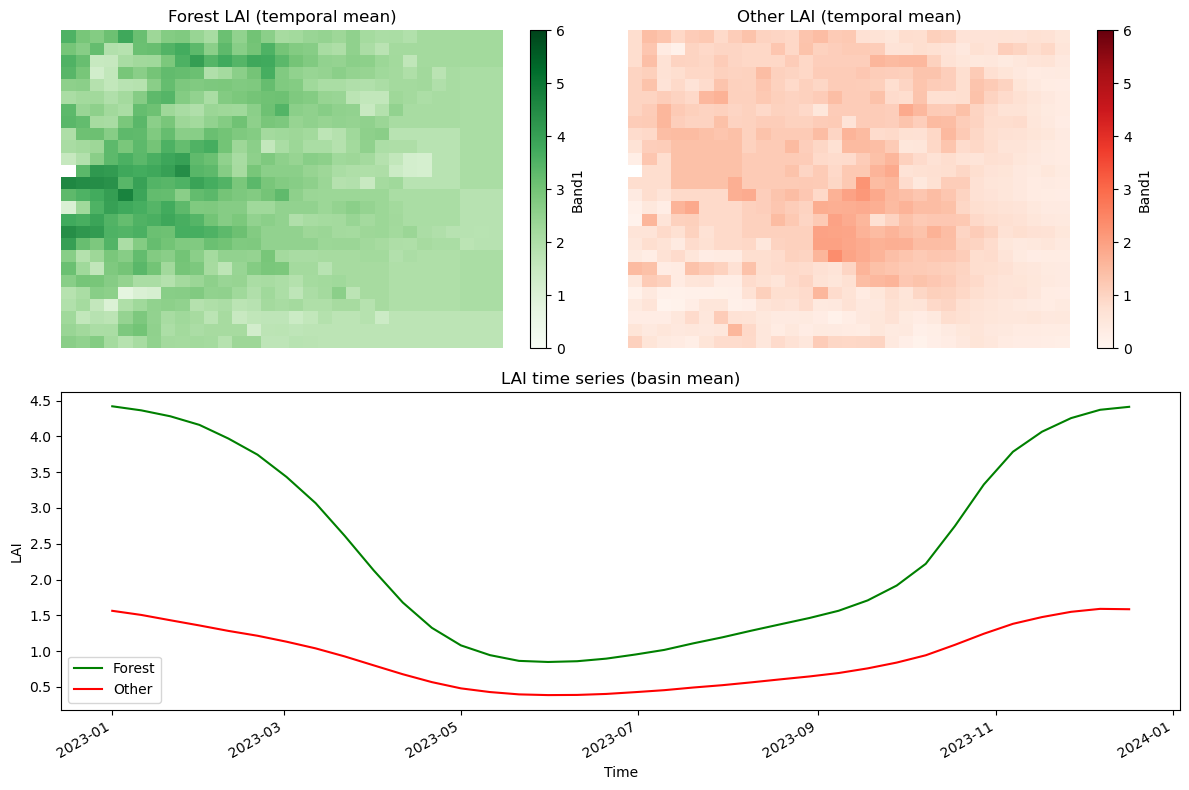

In [24]:
# define paths and variables
path_model = Path('../maps')
variables = ['forest', 'other']
lai = {}

for var in variables:
    filename = f'laif.nc' if var == 'forest' else 'laio.nc'
    ds = xr.open_dataset(path_model / filename)
    lai[var] = ds  # keep the dataset as is

# colormaps
cmaps = {
    'forest': 'Greens',
    'other':  'Reds'
}
cols = {
    'forest': 'green',
    'other':  'red'
}


fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# ---- top row: maps of Band1 (first timestep) ----
for i, var in enumerate(variables):
    ax_map = fig.add_subplot(gs[0, i])
    da = lai[var].Band1.mean(dim="time")
    da.plot(ax=ax_map, cmap=cmaps[var], vmin=0, vmax=6)
    ax_map.set_title(f"{var.capitalize()} LAI (temporal mean)")
    ax_map.axis("off")

# ---- bottom row: time series of spatial mean Band1 ----
ax_ts = fig.add_subplot(gs[1, :])  # spans both columns
for var in variables:
    mean_ts = lai[var].Band1.mean(dim=["lat","lon"])
    mean_ts = mean_ts.assign_coords(
        time=pd.date_range(start="2023-01-01", periods=mean_ts.sizes["time"], freq="10D")
    )
    mean_ts.plot(ax=ax_ts, color=cols[var].lower(), label=var.capitalize())

ax_ts.set_title("LAI time series (basin mean)")
ax_ts.set_xlabel("Time")
ax_ts.set_ylabel("LAI")
ax_ts.legend()

plt.tight_layout()


We nicely see what the LAI files show, they represent the mean seasonal growing cycle of the two land use classes. <br>
In the code above you probably notice that we manually added the time coordinate for a random year (2023) and in total we had 36 timesteps, which is due to the fact that the LAI files provide 10-daily values.

In the next exercise we will focus on some common LISFLOOD-utilities.     

## TESTS (TO BE DELETED)

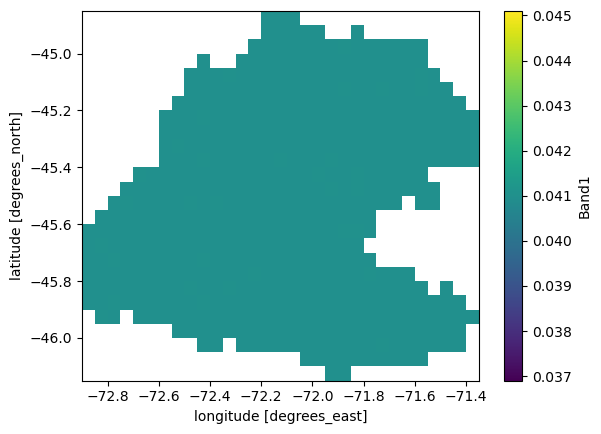

In [84]:
pathtest = Path("/home/schafti/Documents/01_Hydrology/01_Lisflood/00_SourceCode/01_Playground/01_Test_Usecase/create_submodel_7859/7859_testing/cutmaps_check/cutmaps_test_stefania2/thetar2_f_Global2_03min.nc")
test3 = xr.open_dataset(pathtest)
test3.Band1.plot()

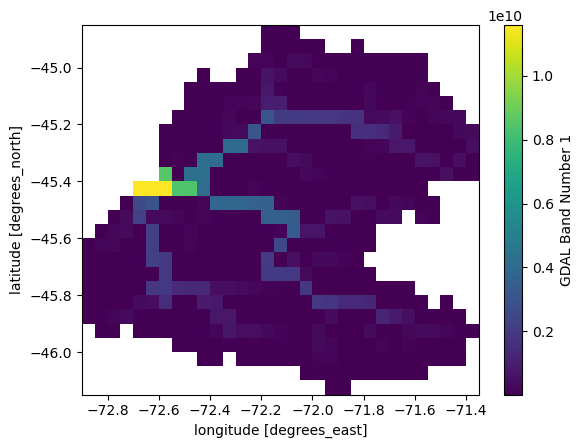

In [ ]:
pathtest = Path("/home/schafti/Documents/01_Hydrology/01_Lisflood/00_SourceCode/01_Playground/01_Test_Usecase/create_submodel_7859/7859_testing/cutmaps_check/cutmaps_test_stefania2/upArea_repaired.nc")
test2 = xr.open_dataset(pathtest)
test2.Band1.plot()

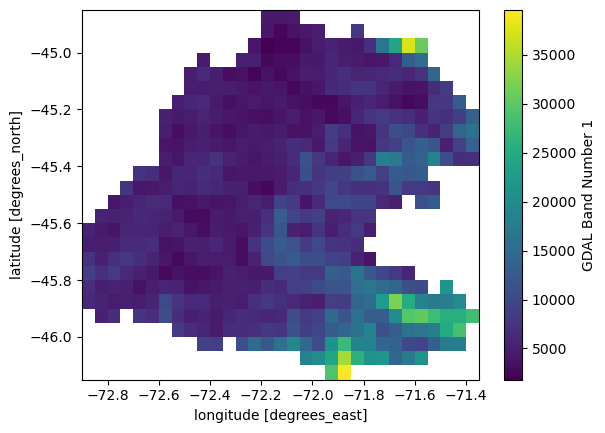

In [82]:
pathtest = Path("/home/schafti/Documents/01_Hydrology/01_Lisflood/00_SourceCode/01_Playground/01_Test_Usecase/create_submodel_7859/7859_testing/cutmaps_check/cutmaps_test_stefania/soildepth3_o_Global_03min_clipped.nc")
test = xr.open_dataset(pathtest)
test.Band1.plot()